Neural network classification. Without XGBoost to see if there is a big difference in accuracy.

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

#Set seed to make reproducible
torch.manual_seed(2024)

#Read in dataset
df = pd.read_csv("diabetes_preprocessed.csv")
# Separate features and target variable
X = df.drop(columns="Outcome").values  # 'Outcome' is the target variable
y = df["Outcome"].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long for classification labels
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader 
training_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data= TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32 #Random, change this

train_loader = DataLoader(training_data, batch_size, shuffle=True) #Want to shuffle to prevent overfitting
test_loader = DataLoader(test_data, batch_size, shuffle=False)


In [50]:
#Define the architecture of our Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.output = nn.Linear(hidden_size3, output_size)
        self.ReLU = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.leakyrelu = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.ReLU(self.fc1(x)) #First hidden layer
        x = self.sigmoid(self.fc2(x))
        x = self.ReLU(self.fc3(x))
        x = self.leakyrelu(self.output(x)) #Output layer
        return x

In [51]:
input_size = X_train.shape[1]
hidden_size1 = 12
hidden_size2 = 8 #Random, change this
hidden_size3 = 10
output_size = 2 #Binary classification (0 and 1), therefore 2 classes

model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

learning_rate = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


In [52]:
def train_loop(dataloader, model, loss_function, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_function(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() #Optimization
        optimizer.zero_grad() #Reset gradients

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_function):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    predictions = [] #Our predictions
    classifications = [] #From the dataset

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            
            predictions.extend(pred.argmax(1).tolist())
            classifications.extend(y.tolist())

    accuracy = accuracy_score(classifications, predictions)

    test_loss /= num_batches
    #print(f"Test Error: \n Accuracy: {100*(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predictions, classifications, accuracy

In [53]:
epochs = 350
best_accuracy = 0
best_predictions = []
best_classifications = []

for epoch in range(epochs):
    #print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_function, optimizer)
    predictions, classifications, accuracy = test_loop(test_loader, model, loss_function)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_predictions = predictions
        best_classifications = classifications
        #torch.save(model.state_dict(), 'best_model.pth')

print("Done!")

Done!


Final accuracy on the test data: 82.5%


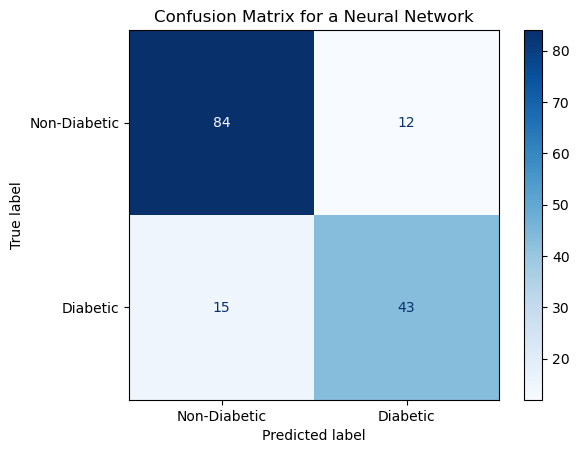

In [54]:
print(f"Final accuracy on the test data: {100*(best_accuracy):>0.1f}%")

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(best_predictions, best_classifications)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Diabetic', 'Diabetic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for a Neural Network")
plt.show()

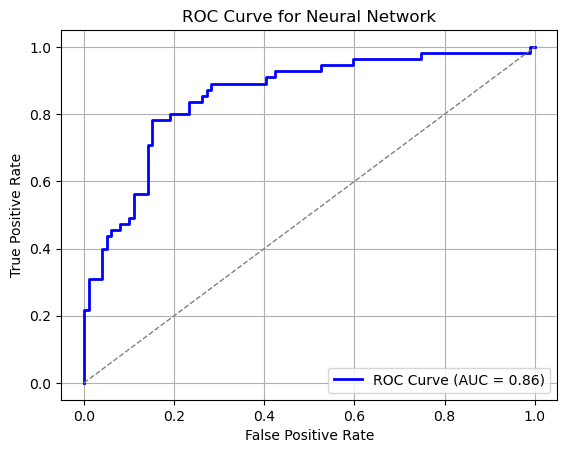

In [55]:
# ROC AUC Plot
# Use predicted probabilities for the positive class (1)
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Neural Network")
plt.legend(loc="lower right")
plt.grid()
plt.show()